In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import signal, optimize
import glob

In [3]:
sobject_id = 150429001101216
sobject_id = 170509006701393 # inaccurate CCD3 wavelength solution\
sobject_id = 170509001701155 # inaccurate CCD3 wavelength solution\

for ccd in [1,2,3,4]:
    fits_file = fits.open('../observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
    crval1 = fits_file[0].header['CRVAL1']
    cdelt1 = fits_file[0].header['CDELT1']
    rv_com = fits_file[0].header['RVCOM']
    rv_ccd = fits_file[0].header['RV']
    fits_file.close()
    print(sobject_id,ccd,crval1,cdelt1,rv_com,rv_ccd)

170509001701155 1 4713.66845703131 0.0460206568605011 18.22764170840212 18.14032806519494
170509001701155 2 5649.15429687501 0.0546991853632481 18.22764170840212 18.5286541895656
170509001701155 3 6477.87670266131 0.0631432859606801 2.918013467175822 3.161959024628821
170509001701155 4 7585.63720703131 0.0735861902854091 18.22764170840212 18.0699274592476


In [4]:
sobject_ids = [int(x[-21:-6]) for x in glob.glob('../observations/170509/spectra/com/17050900*3.fits')]

In [5]:
wavelength_solutions = dict()

for ccd in [1,2,3,4]:

    crvals = []
    cdelts = []

    for sobject_id in sobject_ids:

        fits_file = fits.open('../observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
        crval1 = fits_file[0].header['CRVAL1']
        crvals.append(crval1)
        cdelt1 = fits_file[0].header['CDELT1']
        cdelts.append(cdelt1)
        rv_com = fits_file[0].header['RVCOM']
        rv_ccd = fits_file[0].header['RV']
        fits_file.close()
    #    print(sobject_id,crval1,cdelt1,rv_com,rv_ccd)
    
    wavelength_solutions['crval1_'+str(ccd)] = np.array(crvals)
    wavelength_solutions['cdelt1_'+str(ccd)] = np.array(cdelts)

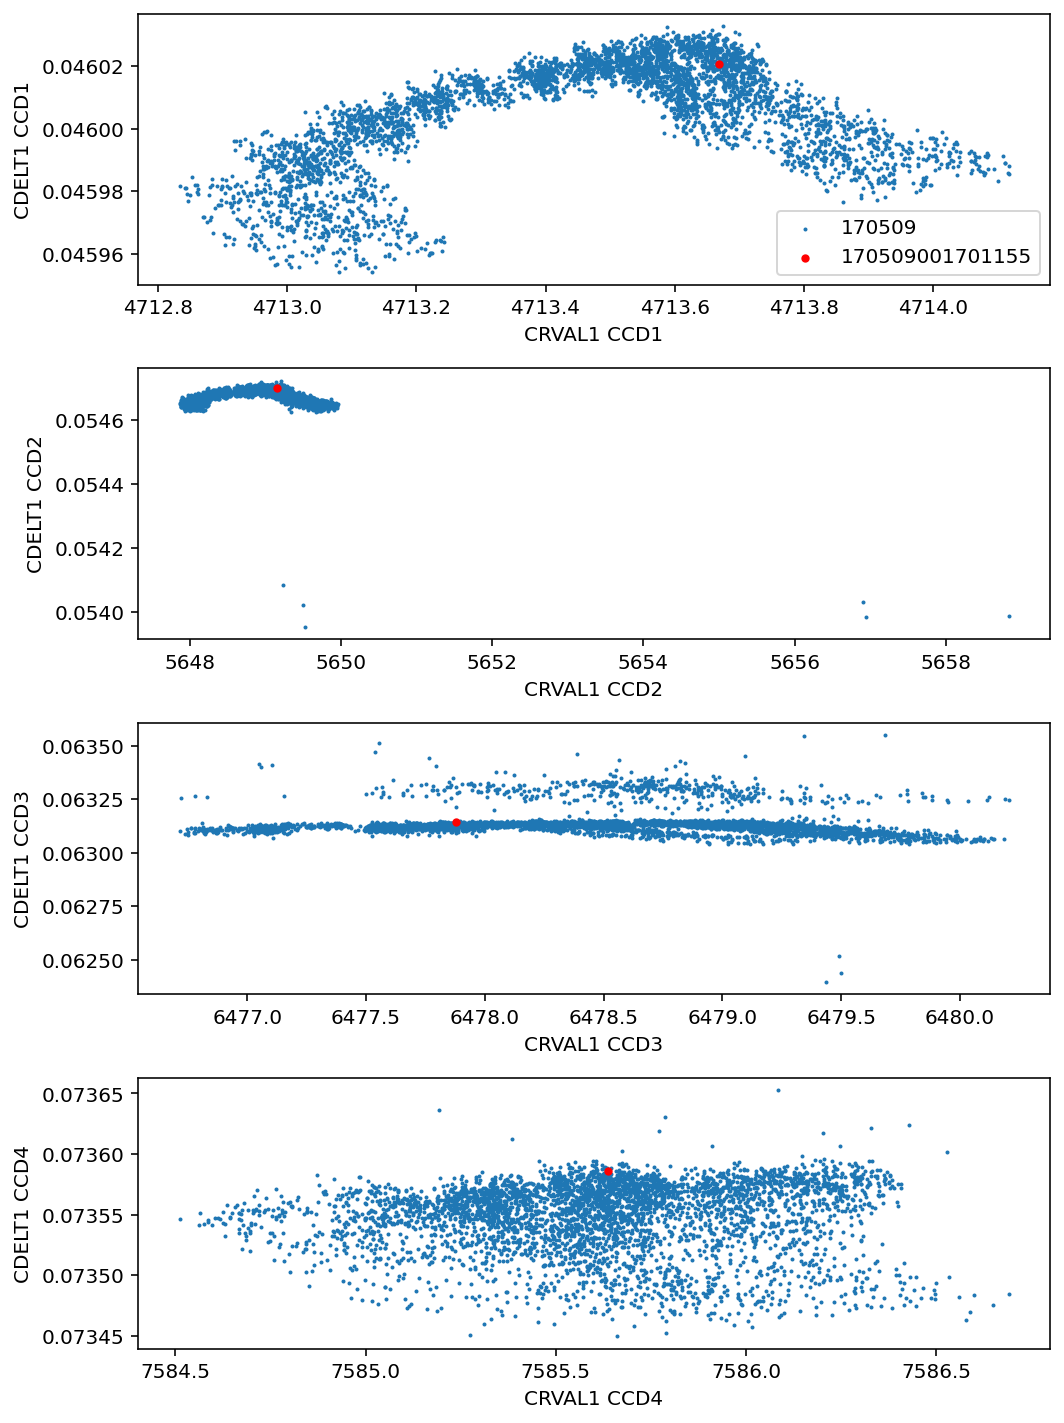

In [6]:
f, gs = plt.subplots(4,1,figsize=(7.5,10))

for ccd in [1,2,3,4]:
    
    ax = gs[ccd-1]

    ax.scatter(
        wavelength_solutions['crval1_'+str(ccd)],
        wavelength_solutions['cdelt1_'+str(ccd)],
        s=1,
        label = '170509'
    )
    plt.tight_layout()
    ax.set_xlabel('CRVAL1 CCD'+str(ccd))
    ax.set_ylabel('CDELT1 CCD'+str(ccd))
    
    sobject_id = 170509001701155
    
    fits_file = fits.open('../observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')
    crval1 = fits_file[0].header['CRVAL1']
    cdelt1 = fits_file[0].header['CDELT1']
    fits_file.close()

    ax.scatter(
        [crval1],
        [cdelt1],
        c = 'r',
        s = 10,
        label = str(170509001701155)
    )
    if ccd == 1:
        ax.legend()
plt.tight_layout()
plt.savefig('figures/galah_dr4_cdelt1_crval1_170509.png',dpi=200,bbox_inches='tight')